In [1]:
# Standard Python modules
import os, sys
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import textwrap
import yaml

# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean

# matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import matplotlib.patheffects as pe

# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature

# extras
%matplotlib inline

# import personal modules
# Path to modules
sys.path.append('../modules')
# Import my modules
from plotter import draw_basemap, add_subregion_boxes, make_cmap
from constants import ucsd_colors
import ar_funcs

ERROR 1: PROJ: proj_create_from_database: Open of /home/dnash/miniconda3/envs/SEAK-impacts/share/proj failed


In [6]:
# Set up paths

path_to_data = '/expanse/nfs/cw3e/cwp140/'
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures


In [7]:
ext1 = [-141., -130., 54.5, 60.] # extent of SEAK 
ext2 = [-175., -120., 50., 75.] # extend of AK
exts = [ext1, ext2]



### Read preprocessed USGS GMTED2010 7.5 arc second elevation data

In [10]:
## Open GMTED2010 7.5 arc second elevation data
# elev = xr.open_dataset(path_to_data + 'preprocessed/seak_gmted_mea075.nc')

### Read Glacier and Stream Shapefile

In [11]:
# fp = path_to_data + 'downloads/Alaska_Glacier_Inventory_RGI/Alaska_Glacier_Inventory_RGI.shp'
# polys = gpd.read_file(fp, bbox=[ext1[0], ext1[3], ext1[1], ext1[2]]) # read shapefile
# crs_polys = ccrs.epsg('3395')
# polys = polys.to_crs("EPSG:3395") # reproject to Mercator

# fp = path_to_data + '/downloads/SEA/sea_stream.shp'
# river = gpd.read_file(fp) # read shapefile
# river = river.to_crs("EPSG:3395") # reproject to Mercator
# crs_polys = ccrs.epsg('3395')
# ## test
# fig, ax = plt.subplots()
# river.plot(ax=ax, facecolor='None', alpha=0.4);
# polys.plot(ax=ax, facecolor='c', alpha=0.4);
# plt.tight_layout();

## Station and City Data

In [12]:
impact_df = ar_funcs.clean_impact_data(start_date = '2000-01-01', end_date = '2019-08-31')
impact_counts = impact_df.groupby('Location')['Impact Level'].count()
impact_counts

Location
COOPHCSA2     9
HONA2         9
KTNA2        14
PAGS          6
PAGY         44
PAHN         18
PAJN         83
PAKT         19
PAKW         16
PAPG          5
PASI         16
PAWG          6
PAYA         16
Name: Impact Level, dtype: int64

In [13]:
## load precipitation station information from config
## read .yaml file with station information
yaml_doc = '../data/ASOS_station_info.yaml'
config = yaml.load(open(yaml_doc), Loader=yaml.SafeLoader)
xs = []
ys = []
lbl1 = []
station_lst = []
impact_ct = []
for i, stationID in enumerate(config):
    station_lst.append(stationID)
    xs.append(float(config[stationID]['lon']))
    ys.append(float(config[stationID]['lat']))
    lbl1.append(config[stationID]['name'])
    impact_ct.append(impact_counts.loc[impact_counts.index == stationID].values.tolist()[0])

## Make Figure

In [15]:
# Set up projection
datacrs = ccrs.PlateCarree()  ## the projection the data is in
mapcrs = ccrs.Mercator() ## the projection you want your map displayed in

# Set tick/grid locations
ext1 = [-141., -130., 54.5, 60.] # extent of SEAK 
ext3 = [-136.15, -135.1, 59.15, 59.6] # extent of Klukwan and Skagway
dx = np.arange(ext1[0],ext1[1]+2,2)
dy = np.arange(ext1[2]-.5,ext1[3]+1,1)

# make a colormap that has land and ocean clearly delineated and of the
# same length (256 + 256)
colors_undersea = plt.cm.terrain(np.linspace(0, 0.17, 256))
colors_land = plt.cm.terrain(np.linspace(0.25, 1, 256))
all_colors = np.vstack((colors_undersea, colors_land))
terrain_map = mcolors.LinearSegmentedColormap.from_list(
    'terrain_map', all_colors)
# make the norm:  Note the center is offset so that the land has more
# dynamic range:
divnorm = mcolors.TwoSlopeNorm(vmin=-0.25, vcenter=1, vmax=3000)

# lons = elev.lon
# lats = elev.lat

wc_rgb = (86./255., 105./255., 166./255.) # color for water features
wc_cmyk = (48., 37., 0., 35.)


In [28]:
## bounding boxes for composite analysis
bboxes = [[-140.5, -137., 58.25, 60.75], # Yakutat (Northern Coastal)
          [-136.5, -134.75, 56.0, 58.25], # Sitka / Hoonah (Central Coastal)
          [-137.0, -134.75, 58.25, 60.5], # Skagway/Klukwan/Haines (Northern Inner Channel)
          [-134.75, -132.5, 56.75, 58.5], # Juneau/Hoonah/Gustavas (Central Inner Channel)
          [-134.25, -132.5, 54.25, 56.75], # Craig (Southern Coastal)
          [-132.5, -131.25, 54.5, 56.75]] # Kasaan (Southern Inner Channel)

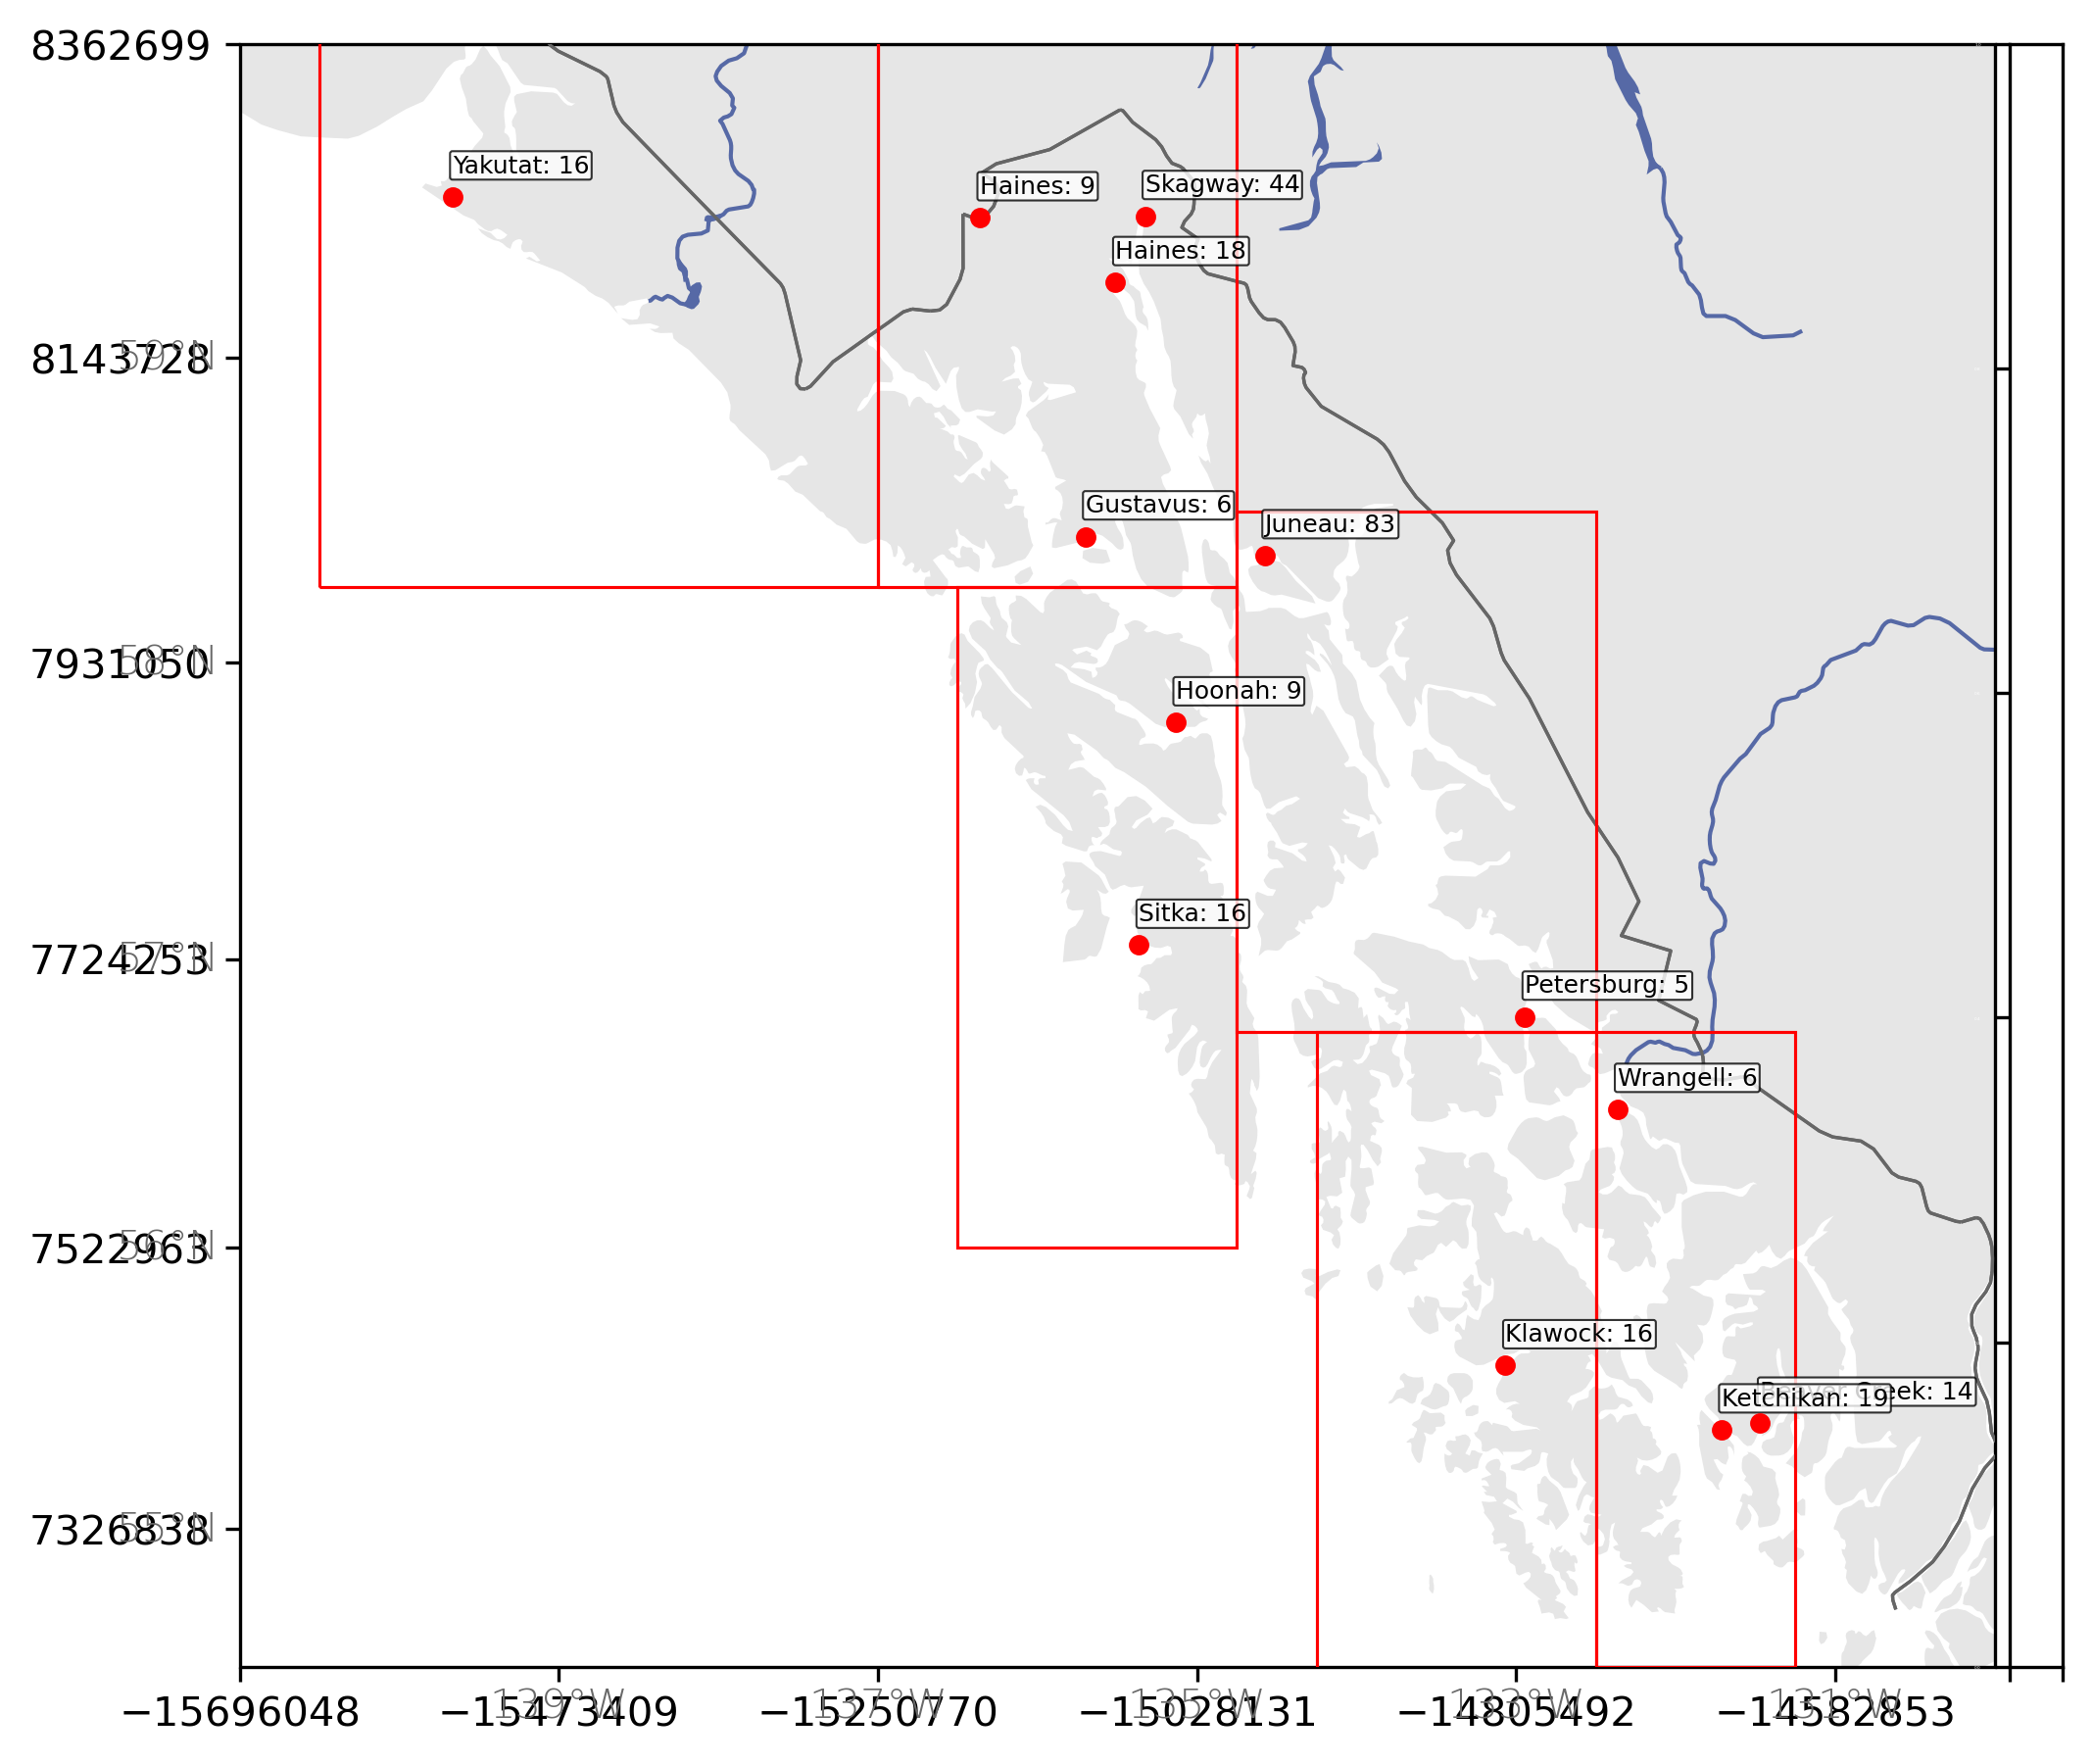

In [29]:
# Create figure
fig = plt.figure(figsize=(8, 12))
fig.dpi = 300
fname = path_to_figs + 'elevation_7.5arcsec_with_inset'
fmt = 'png'

nrows = 1
ncols = 1

# Set up Axes Grid
axes_class = (GeoAxes,dict(projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.45,
                cbar_location='right', cbar_mode='single',
                cbar_pad=0.05, cbar_size='3%',label_mode='keep')


for k, ax in enumerate(axgr):
    ax = draw_basemap(ax, extent=ext1, xticks=dx, yticks=dy,left_lats=True, right_lats=False, mask_ocean=False, coastline=False)

    # topo with bright cmap
    # cs = ax.pcolormesh(lons, lats, elev.hillshade,
    #                     cmap=cmo.gray, transform=datacrs, alpha=0.7)
    
    # cf = ax.pcolormesh(lons, lats, elev.elev, rasterized=True, norm=divnorm,
    #                     cmap=terrain_map, shading='auto', transform=datacrs, alpha=0.6)
    
    
    # # add glaciers
    # ax.add_geometries(polys['geometry'], crs=crs_polys,
    #                   facecolor=(0.7, 1, 1, 0.7), ec='None',
    #                   zorder=100, alpha=0.5)
    
    # # add rivers/streams
    # ax.add_geometries(river['geometry'], crs=crs_polys,
    #                   facecolor='None', ec=wc_rgb, linewidth=0.5,
    #                   zorder=99)

    ax.add_feature(cfeature.LAKES, facecolor=wc_rgb)
    ax.add_feature(cfeature.RIVERS, edgecolor=wc_rgb)
    ax.add_feature(cfeature.BORDERS, edgecolor='0.4', linewidth=0.8, zorder=199)
    
    # need this to fix annotate transform
    transform = datacrs._as_mpl_transform(ax)
    
    ## Plot the locations of the focus communities
    # zip joins x and y coordinates in pairs
    for x,y,z,ct in zip(xs,ys,lbl1,impact_ct):

        # Plot Location of pts
        ax.plot(x, y, 'ro', markersize=4, transform=datacrs, zorder=201)

        ax.annotate('{0}: {1}'.format(z, ct), # this is the text
                   (x,y), # these are the coordinates to position the label
                    textcoords="offset points", # how to position the text
                    xytext=(0,6), # distance from text to points (x,y)
                    ha='left', # horizontal alignment can be left, right or center
                    bbox=dict(boxstyle="round,pad=0.1", fc="white", ec="k", lw=0.5, alpha=0.8),
                    xycoords=transform,
                    zorder=200,
                    fontsize=6)

    for j, ext in enumerate(bboxes):
        ax.add_patch(mpatches.Rectangle(xy=[ext[0], ext[2]], width=ext[1]-ext[0], height=ext[3]-ext[2],
                                    fill=False,
                                    edgecolor='r',
                                    linewidth=0.75,
                                    transform=datacrs,
                                    zorder=199))


# # Colorbar (single)
# cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='vertical', drawedges=False)
# cb.set_label('Elevation (m)', fontsize=11)
# cb.ax.tick_params(labelsize=10)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)

# Show
plt.show()